# Python classifier based on VFI algorithm (Voting Feature Intervals)             

For now this implementation only processes numerical data, not nominal.

The classifier expects data to be in numpy array andmissing data be of type np.nan in order
to avoid them correctly, so you should convert your dataset accordingly (i.e. replace ? with np.nan for example).

Based on the VFI algorithm as described in : https://link.springer.com/content/pdf/10.1007/3-540-62858-4_74.pdf


In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import numpy as np
from multiprocessing import Pool
from multiprocessing import cpu_count

# Based on a sklearn default classifier template
class VFIClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self):
        pass
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        # Commented because we do accept NaN values... they are handled later on in the code below
        # Another possibility would be to impute missing values (mean, median, ...)
        
        #X, y = check_X_y(X, y) 
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        # To store the mins and maxs (end points) found for each class, and for each feature
        self.mins_maxs_classes_ = [[[None,None] for _ in range(self.classes_.size)] for _ in range(self.X_.T.shape[0])]
        
        # To store the endpoints of each interval (the begining of an interval is the end of the previous one)
        self.end_points_ = []
        
        self.bins_ = []
        
        # Iterating on X transposed, so on the columns (features) of the train data
        for feature in range(len(self.X_.T)):
            # Parsing all the rows of the training data (X)
            for row in range(len(self.X_)):
                # If the min for the currently parsed line's class has not been initialized
                # we initialize it as the current min
                if self.mins_maxs_classes_[feature][self.y_[row]][0] == None:
                    self.mins_maxs_classes_[feature][self.y_[row]][0] = self.X_[row, feature]
                # If the max for the currently parsed line's class has not been initialized
                # we initialize it as the current max
                if self.mins_maxs_classes_[feature][self.y_[row]][1] == None:
                    self.mins_maxs_classes_[feature][self.y_[row]][1] = self.X_[row, feature]
                # If a feature value is less than the min for this line's class
                # we store is as the new min
                if self.X_[row, feature] < self.mins_maxs_classes_[feature][self.y_[row]][0] :
                    self.mins_maxs_classes_[feature][self.y_[row]][0] = self.X_[row, feature]
                # If a feature value is more than the max for this line's class
                # we store is as the new max
                if self.X_[row, feature] > self.mins_maxs_classes_[feature][self.y_[row]][1] :
                    self.mins_maxs_classes_[feature][self.y_[row]][1] = self.X_[row, feature]
        
        # Fill the endpoints list
        for feature in self.mins_maxs_classes_:
            # Flattens each line of mins maxs
            feature_endpoints = [item for sublist in feature for item in sublist]
            # Removes potential duplicates by creating a set then casting back to list
            feature_endpoints = list(set(feature_endpoints))
            # Sort endpoints by ascending order to create intervals
            feature_endpoints.sort()
            self.end_points_.append(feature_endpoints)

        # Create the intervals: store the number of members of each class in each interval for each feature
        for feature in range(len(self.X_.T)):
            # For each feature there will be number_of_intervals * number_of_classes bins
            # The number of intervals is number_of_endpoints - 1 + 2 (because of -inf, +inf
            # which create 2 more intervals...). So it ends up adding 1 to the number of endpoints.
            feature_bins = [[0 for _ in range(self.classes_.size)] for _ in range(len(self.end_points_[feature])+1)]
            # Parsing all the rows for this feature
            for row in range(len(self.X_)):
                # Extract feature value at this row
                feature_val = self.X_[row, feature]
                # Skip to next iteration for NaN values
                if feature_val == np.nan:
                    break
                # Find the bin and assign +1 to it (or 0.5 to both bins if feature_val == endpoint)
                for position,endpoint in enumerate(self.end_points_[feature]):
                    # If we are on the first interval we check for both [-inf:1st] and [1st:2nd] intervals
                    if position == 0:
                        # feature_val is in [-inf:1st] interval
                        if feature_val < endpoint:
                            feature_bins[position][self.y_[row]] += 1
                        # feature_val is exactly on the endpoint
                        elif feature_val == endpoint:
                            feature_bins[position][self.y_[row]] += 0.5
                            feature_bins[position+1][self.y_[row]] += 0.5
                        # feature_val is in [1st:2nd] interval
                        elif feature_val < self.end_points_[feature][position+1]:
                            feature_bins[position+1][self.y_[row]] += 1
                    # If we are on the last endpoint, we check for [last:inf] interval
                    elif position == (len(self.end_points_[feature])-1):
                        # feature_val is in [last:inf] interval
                        if feature_val > endpoint:
                            #print(f"   intervalle {position+1} += 1")
                            feature_bins[position+1][self.y_[row]] += 1
                        # feature_val is exactly on the endpoint
                        elif feature_val == endpoint:
                            feature_bins[position][self.y_[row]] += 0.5
                            feature_bins[position+1][self.y_[row]] += 0.5
                    
                    # We are neither on the first nor the last endpoint
                    else:
                        # If feature val is in [endpoint:next_endpoint] interval, increment this interval's bin
                        if (feature_val > endpoint) & (feature_val < self.end_points_[feature][position+1]):
                            feature_bins[position+1][self.y_[row]] += 1
                        # feature_val is exactly on the endpoint
                        elif feature_val == endpoint:
                            feature_bins[position][self.y_[row]] += 0.5
                            feature_bins[position+1][self.y_[row]] += 0.5

            self.bins_.append(feature_bins)
            
        # Return the classifier
        return self
    
    def predict(self, X):
        # Check is fit had been called
        # Commented because we do accept NaN values... they are handled later on in the code below
        
        #check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        # Commented because we do accept NaN values... they are handled later on in the code below.
        
        #X = check_array(X)
        
        # To store the global class votes (summing of all votes on all intervals for each feature)
        # There will be as many class votes as lines to be classified (lines in X)
        class_votes = [[0 for _ in range(self.classes_.size)] for _ in range(X.shape[0])]

        found_classes = np.zeros(X.shape[0])

        self.mins_maxs_classes_ = [[[None,None] for _ in range(self.classes_.size)] for _ in range(self.X_.T.shape[0])]

        # Classify all instances passed in parameter X
        for row in range(X.shape[0]):
            # Parse all features
            for feature in range(len(self.X_.T)):
                feature_val = X[row, feature]
                # Skip to next iteration for NaN values
                if feature_val == np.nan:
                    break
                # Count the votes for each class
                for class_ in range(self.classes_.size):
                    # Compute the sum of all bins for this class on this feature
                    class_bin_sum = sum(x[class_] for x in vfi_classifier.bins_[feature])
                    # Avoid division by zero
                    if class_bin_sum != 0:
                        # Determine the interval in which this feature stands
                        for position,endpoint in enumerate(self.end_points_[feature]):
                            # If we are on the first interval we check for both [-inf:1st] and [1st:2nd] intervals
                            if position == 0:
                                # feature_val is in [-inf:1st] interval
                                if feature_val < endpoint:
                                    # Add this class's votes for this interval to the global class_votes
                                    class_votes[row][class_] += self.bins_[feature][position][class_]/class_bin_sum
                                # feature_val is exactly on the endpoint
                                elif feature_val == endpoint:
                                    # add the mean of both intervals class votes (sum/2)
                                    class_votes[row][class_] += (
                                    ((self.bins_[feature][position][class_]/class_bin_sum
                                    + self.bins_[feature][position+1][class_])/2) / class_bin_sum)
                                # feature_val is in [1st:2nd] interval
                                elif feature_val < self.end_points_[feature][position+1]:
                                    class_votes[row][class_] += self.bins_[feature][position+1][class_]/class_bin_sum
                            # If we are on the last endpoint, we check for [last:inf] interval
                            elif position == (len(self.end_points_[feature])-1):
                                # feature_val is in [last:inf] interval
                                if feature_val > endpoint:
                                    class_votes[row][class_] += self.bins_[feature][position+1][class_]/class_bin_sum
                                elif feature_val == endpoint:
                                    class_votes[row][class_] += (
                                    ((self.bins_[feature][position][class_]/class_bin_sum
                                    + self.bins_[feature][position+1][class_])/2) / class_bin_sum)

                            # We are neither on the first nor the last endpoint
                            else:
                                # If feature val is in [endpoint:next_endpoint] interval
                                if (feature_val > endpoint) & (feature_val < self.end_points_[feature][position+1]):
                                    class_votes[row][class_] += self.bins_[feature][position+1][class_]/class_bin_sum
                                # feature_val is exactly on the endpoint
                                elif feature_val == endpoint:
                                    class_votes[row][class_] += (
                                    ((self.bins_[feature][position][class_]/class_bin_sum
                                    + self.bins_[feature][position+1][class_])/2) / class_bin_sum)
                                
            found_classes[row] = np.argmax(class_votes[row])

        return found_classes

    def chunk(self, data, parts):
        divided = [None]*parts
        n = len(data) // parts
        for i in range(parts):
            divided[i] = data[i*n:n*(i+1)]
        if len(data) % 2 != 0:
            divided[-1] += [data[-1]]
        return divided
    
    # Parallelized version of the predict function (as many processes as cpu_count)
    def predict_parallel(self, X):
        workers = cpu_count()
        data_chunks = self.chunk(X, X.shape[0])
        classes = []
        with Pool(workers) as p:
            classes += zip(*p.map(self.predict, data_chunks))
        return classes[0]


In [3]:
# Imports required for this notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [52]:
# Test on Iris dataset

iris = datasets.load_iris()
irisdata = iris.data
irisclasses = iris.target

# Create train and test datasets to evaluate generalization performance of the model
# No need to stratify here because the dataset is balanced (50 samples for each of the 3 classes)
# random_state fixed for reproductibility
X_train, X_test, y_train, y_test = train_test_split(irisdata, irisclasses, test_size=0.3, shuffle=True, random_state=9)

# Preprocessing : centering (removing the mean) and scaling data (divide by std)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
# Applying same scaling on the test set as on the train set
X_test_sc = sc.transform(X_test)

vfi_classifier = VFIClassifier()

# Repeat cross validation a hundred times to reduce the variance
accuracies_stratified = []
for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_sc, y_train):
        x_train_fold, x_test_fold = X_train_sc[train_index], X_train_sc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        vfi_classifier.fit(x_train_fold, y_train_fold)
        y_pred = vfi_classifier.predict_parallel(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


Maximum Accuracy that can be obtained from this model: 100.0 %

Minimum Accuracy: 71.42857142857143 %

Overall Accuracy: 93.11428571428571 %

Standard Deviation is: 0.05343281538190916


In [53]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
vfi_classifier.fit(X_train_sc, y_train)
y_pred = vfi_classifier.predict_parallel(X_test_sc)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 1.0


In [4]:
### Comparison with classic k-NN algorithm

knn = KNeighborsClassifier(n_neighbors=15)

# Repeat the CV a hundred times to reduce variance
accuracies_stratified = []
for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_sc, y_train):
        x_train_fold, x_test_fold = X_train_sc[train_index], X_train_sc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        knn.fit(x_train_fold, y_train_fold)
        y_pred = knn.predict(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 288.41it/s]


Maximum Accuracy that can be obtained from this model: 100.0 %

Minimum Accuracy: 71.42857142857143 %

Overall Accuracy: 92.19047619047619 %

Standard Deviation is: 0.05186761449215277


In [6]:
knn.fit(X_train_sc, y_train)
y_pred = knn.predict(X_test_sc)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 1.0


#### Both algorithms have roughly the same perf on this dataset if we look at the cross-validation results.
#### They both have 100% accuracy on the test set.

In [14]:
!pip install ucimlrepo

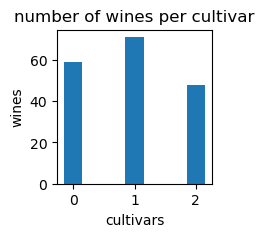

In [119]:
### Test k-NNFP on the Wine dataset (UCI) : predict the origin (cultivar) of wines basing on their
### chemical composition

from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# Fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# Data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

# Converts the dataframe into a numpy array, and stores the classes in a separate np array
X = X.to_numpy()
X = np.array(X).astype(float)
y = y.to_numpy()
y = np.array(y).astype(int)
y = y.ravel() #Converts the classes in scikit-learn format (1d list)

# Changes the range of classes to be 0 to n (instead of 1 to n)
y = y - np.array([1]*y.shape[0])

# Display the number of members of each class in a bar graph
unique, counts = np.unique(y, return_counts=True)
index = unique #range(3,9) # il y a 10 notes possibles
plt.figure(figsize=(2,2))
plt.bar(index, counts, width=0.3)
plt.xlabel('cultivars', fontsize=10)
plt.ylabel('wines', fontsize=10)
plt.title('number of wines per cultivar')
#plt.rcParams["figure.figsize"] = (4, 5)
plt.show()

In [120]:
# Create train and test datasets to evaluate generalization performance of the model
# Doing stratify here because of imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

#Preprocessing : centering (removing the mean) and scaling data (divide by std)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
# Applying same scaling on the test set as on the train set
X_test_sc = sc.transform(X_test)

vfi_classifier = VFIClassifier()

# Appart from evaluating on a separate test set, we also do cross-validation for estimation of model perf.
# Since the dataset is imbalanced, we use StratifiedKFold cross-validation.
# This cross-validation is performed on the X_train set and not on the whole dataset, in order to be
# consistent with the final evaluation on test set, which uses X_train for training too.

# Repeat the CV a hundred times to reduce variance
accuracies_stratified = []
for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_sc, y_train):
        x_train_fold, x_test_fold = X_train_sc[train_index], X_train_sc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        vfi_classifier.fit(x_train_fold, y_train_fold)
        y_pred = vfi_classifier.predict_parallel(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Maximum Accuracy that can be obtained from this model: 96.55172413793103 %

Minimum Accuracy: 64.28571428571429 %

Overall Accuracy: 83.54704433497537 %

Standard Deviation is: 0.05428043360501346


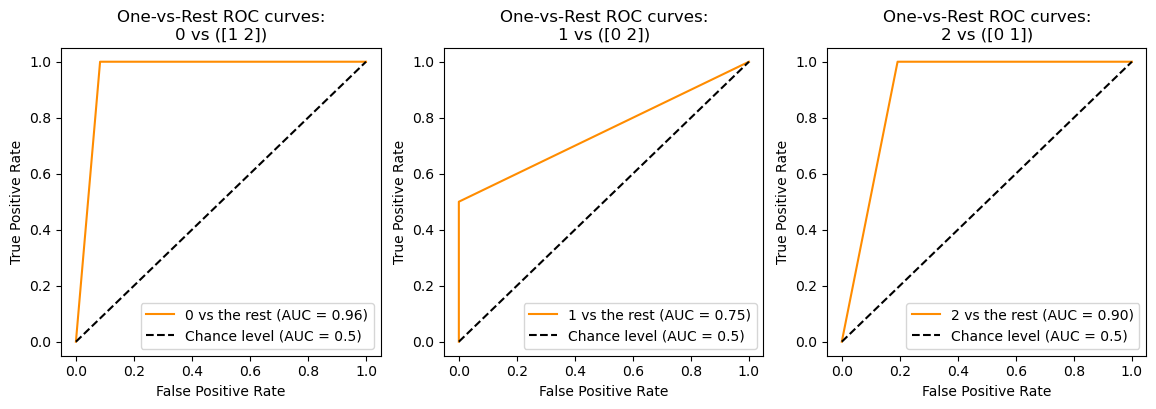

In [121]:
# One-vs-Rest multiclass ROC : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

#In this section we use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion.
#This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
# y_onehot_test.shape  # (n_samples, n_classes). here : (36, 3)


# Predicts the classes on the test set, and one-hot-encode them
vfi_classifier.fit(X_train_sc, y_train)
y_pred = vfi_classifier.predict(X_test_sc)
y_pred = label_binarizer.transform(y_pred)

# prepare a figure with "number of classes" suplots on one line
fig, (ax1, ax2, ax3) = plt.subplots(1, label_binarizer.classes_.shape[0], figsize=(14, 4))
axes = [ax1, ax2, ax3]

for class_of_interest in label_binarizer.classes_:
    # Preparing ROC OvR : 1 class vs other classes
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    # Draw ROC curve
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[class_of_interest]
    )
    axes[class_of_interest].set_xlabel("False Positive Rate")
    axes[class_of_interest].set_ylabel("True Positive Rate")
    all_classes = label_binarizer.classes_
    # Create the np array containing all classes except the class of interest
    rest_classes = np.delete(all_classes, np.where(all_classes == class_of_interest))
    axes[class_of_interest].set_title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs ({rest_classes})")

plt.show()


In [122]:
# Final evaluation on the test set
# We should keep in mind that a randomly chosen test set will produce high variance in the results
# if train/test split + eval is repeated, as compared with cross-validation.
vfi_classifier.fit(X_train_sc, y_train)
y_pred = vfi_classifier.predict(X_test_sc)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8055555555555556


In [21]:
### Comparison with classic k-NN algorithm
knn = KNeighborsClassifier(n_neighbors=5)
accuracies_stratified = []

# Doing 100 CV to reduce variance of the results (Shuffle=True)
for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_sc, y_train):
        x_train_fold, x_test_fold = X_train_sc[train_index], X_train_sc[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        knn.fit(x_train_fold, y_train_fold)
        y_pred = knn.predict(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.72it/s]


Maximum Accuracy that can be obtained from this model: 100.0 %

Minimum Accuracy: 82.14285714285714 %

Overall Accuracy: 94.53349753694582 %

Standard Deviation is: 0.03961678250674524


In [22]:
# Final evaluation on the test set
knn.fit(X_train_sc, y_train)
y_pred = knn.predict(X_test_sc)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 1.0


#### On this dataset, VFI doesn't perform as good as KNN
#### It has only 80% accuracy on test set, as compared with 100% with KNN

In [32]:
### Test on the Dermatology dataset (UCI) : skin disease diagnostic (classification task)

col_list = [*range(0,34,1)]
data_frame = pd.read_csv("./datasets/DermatologyDataset/dermatology.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

col_list = [34]
classes = pd.read_csv("./datasets/DermatologyDataset/dermatology.data", sep=",", header=None, usecols=col_list, encoding ='latin1')

# Replace missing values with np.nan (which our classifier handles)
data_frame.replace('?',np.nan, inplace=True)

# Converts the dataframe into a numpy array, and stores the classes in a separate np array
dermato_data = data_frame.to_numpy()
dermato_data = np.array(dermato_data).astype(float)
dermato_classes = classes.to_numpy()
dermato_classes = np.array(dermato_classes).astype(int)
dermato_classes = dermato_classes.ravel() #met les classes sous la forme demandée par scikit-learn (liste 1d)

# Changes the range of classes to be 0 to n (instead of 1 to n)
dermato_classes = dermato_classes - np.array([1]*dermato_classes.shape[0])

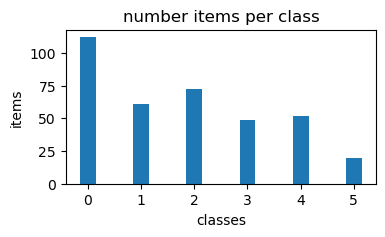

In [33]:
# Display the number of members of each class in a bar graph
unique, counts = np.unique(dermato_classes, return_counts=True)
index = unique #range(3,9) # il y a 10 notes possibles
plt.figure(figsize=(4,2))
plt.bar(index, counts, width=0.3)
plt.xlabel('classes', fontsize=10)
plt.ylabel('items', fontsize=10)
plt.title('number items per class')
#plt.rcParams["figure.figsize"] = (4, 5)
plt.show()

In [36]:
# Create train and test datasets to evaluate generalization performance of the model
# Doing stratify here because of imbalanced dataset
# random_state fixed for reproductibility

# Random shuffling to avoid a (possible) pre-existing ordering in the data
dermato_data, dermato_classes = shuffle(dermato_data, dermato_classes)

X_train, X_test, y_train, y_test = train_test_split(dermato_data, dermato_classes, stratify=dermato_classes, test_size=0.2)

#Preprocessing : centering (removing the mean) and scaling data (divide by std)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
# Applying same scaling on the test set as on the train set
X_test_sc = sc.transform(X_test)

# Doing imputation, because we also need to do it for k-NN algorithm comparison (doesn't accept nans)
# So we want the datasets to be equal for comparing both algorithms.
# Experimental mode necessary for iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
imp = IterativeImputer(missing_values=np.nan, estimator=RandomForestRegressor())
imp.fit(X_train_sc)
X_train_imputed = imp.transform(X_train_sc)
imp.fit(X_test_sc)
X_test_imputed = imp.transform(X_test_sc)

# Appart from evaluating on a separate test set, we also do cross-validation for estimation of model perf.
# Since the dataset is imbalanced, we use StratifiedKFold cross-validation.
# This cross-validation is performed on the X_train set and not on the whole dataset, in order to be
# consistent with the final evaluation on test set, which uses X_train for training too.
vfi_classifier = VFIClassifier()
accuracies_stratified = []

for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_imputed, y_train):
        x_train_fold, x_test_fold = X_train_imputed[train_index], X_train_imputed[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        vfi_classifier.fit(x_train_fold, y_train_fold)
        y_pred = vfi_classifier.predict_parallel(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

/home/micmac/anaconda3/envs/vfi/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/micmac/anaconda3/envs/vfi/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Maximum Accuracy that can be obtained from this model: 96.55172413793103 %

Minimum Accuracy: 52.54237288135594 %

Overall Accuracy: 79.00637054354179 %

Standard Deviation is: 0.08435452749554458


In [37]:
# Final evaluation on the test set
vfi_classifier.fit(X_train_imputed, y_train)
y_pred = vfi_classifier.predict_parallel(X_test_imputed)
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")

test accuracy: 0.8783783783783784


In [28]:
### Comparing with classic k-NN algorithm
knn = KNeighborsClassifier(n_neighbors=5)
accuracies_stratified = []

# Doing 100 CV to reduce variance of the results (Shuffle=True)
for i in tqdm(range(100)):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in skf.split(X_train_imputed, y_train):
        x_train_fold, x_test_fold = X_train_imputed[train_index], X_train_imputed[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        knn.fit(x_train_fold, y_train_fold)
        y_pred = knn.predict(x_test_fold)
        accuracies_stratified.append(accuracy_score(y_test_fold, y_pred))

#print('List of possible accuracies:', accuracies_stratified)
print('\nMaximum Accuracy that can be obtained from this model:', max(accuracies_stratified)*100, '%')
print('\nMinimum Accuracy:', min(accuracies_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(accuracies_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(accuracies_stratified))

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.05it/s]


Maximum Accuracy that can be obtained from this model: 100.0 %

Minimum Accuracy: 89.65517241379311 %

Overall Accuracy: 96.74751607247224 %

Standard Deviation is: 0.020722488122094616


In [30]:
# Final evaluation on the test set
knn.fit(X_train_imputed, y_train)
y_pred = knn.predict(X_test_imputed)
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")

test accuracy: 0.9324324324324325


### VFI is not bad with 79% accuracy overall and 87% on test set
### But still inferior to KNN...

In [38]:
# Changes the width of Jupyter-Lab notebook
from IPython.core.display import display, HTML
display(HTML("<style>.jp-Cell { width: 80% !important; }</style>"))

/tmp/ipykernel_2279393/4179403743.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [25]:
# Changes the width of Jupyter-Lab notebook
from IPython.core.display import display, HTML
display(HTML("<style>.jp-Cell { width: 100% !important; }</style>"))

/tmp/ipykernel_6592/579905470.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
